In [1]:
import pickle
import json
import pathlib
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append('../src')
from loss import zero_one_loss, log_loss

In [2]:
with open('../config.json') as f:
    config = json.load(f)
dn0 = pathlib.Path(config['dir'])

In [3]:
def load_train(data, model, option, loss_fn, random_state=0):
    dn = dn0.joinpath('preds/%s/%s/' % (data, model))
    if loss_fn == 'zo':
        loss_fn = zero_one_loss
    elif loss_fn == 'log':
        loss_fn = log_loss
    Lte = []
    for o in option:
        fn = dn.joinpath('p_opt%05d_seed%02d.pkl' % (o, random_state))
        with open(str(fn), 'rb') as f:
            _, yte, _, _, _, pte = pickle.load(f)
        L = loss_fn(pte)
        Lte.append(np.mean(np.array([L[i, c] for i, c in enumerate(yte)])))
    return np.array(Lte)

In [4]:
def load_file(sec, data, method, model, surrogate, loss_fn, seed):
    dn = dn0.joinpath('Sec5%d/%s/%s/%s/%s' % (sec, data, model, surrogate, loss_fn))
    dnn = dn.joinpath(method)
    fn = dnn.joinpath('seed%03d.pkl' % (seed,))
    with open(str(fn), 'rb') as f:
        res = pickle.load(f)
    return res

def load_mean_std(sec, data, method, model, surrogate, loss_fn, seed):
    res = load_file(sec, data, method, model, surrogate, loss_fn, seed)
    Ltrue, (opt, others), hat = res['Lavg'], res['opt'], res['hat']
    opt2 = others[np.argmin(Ltrue[others])]
    Ldiff = np.mean(Ltrue[opt]) - Ltrue[opt2]
    mean = np.mean(np.array([np.mean(hat[:, :, o] - hat[:, :, opt2], axis=0) for o in opt]), axis=0)
    std = np.mean(np.array([np.std(hat[:, :, o] - hat[:, :, opt2], axis=0) for o in opt]), axis=0)
    return Ldiff, mean, std

def load_success(sec, data, method, model, surrogate, loss_fn, seed):
    res = load_file(sec, data, method, model, surrogate, loss_fn, seed)
    return res['success']

def load_qnum(sec, data, method, model, surrogate, loss_fn, seed):
    res = load_file(sec, data, method, model, surrogate, loss_fn, seed)
    return res['q_num']

In [5]:
def show_Lavg(data, model, option, loss_fn, seed):
    Lte = load_train(data, model, option, loss_fn, seed)
    print(data, model, loss_fn, Lte)

def plot_mean_std(sec, data, methods, model, surrogate, loss_fn, seed):
    s0 = 0
    for key, (method, c, cc) in methods.items():
        d, m, s = load_mean_std(sec, data, key, model, surrogate, loss_fn, seed)
        if key == 'proposed':
            s0 = s[0]
        x = range(m.size)
        plt.fill_between(x, m+s, m-s, color=c)
        plt.plot(x, m, color=cc, lw=2, label=method)
        plt.plot(x, m+s, '--', color=cc, lw=2)
        plt.plot(x, m-s, '--', color=cc, lw=2)
    plt.plot([0]*m.size, 'k-', lw=2)
    plt.xlim([0, m.size])
    plt.ylim([-1.3 * s0, 1.3 * s0])
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)

def plot_success(sec, data, methods, model, surrogate, loss_fn, seed):
    for key, (method, _, cc) in methods.items():
        s = load_success(sec, data, key, model, surrogate, loss_fn, seed)
        x = range(len(s))
        plt.plot(x, s, color=cc, label=method)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)

def plot_qnum(sec, data, methods, model, surrogate, loss_fn, seed):
    q, cl = [], []
    for key, (_, _, cc) in methods.items():
        q.append(load_qnum(sec, data, key, model, surrogate, loss_fn, seed))
        cl.append(cc)
    q = np.array(q)
    plt.hist(q.T, bins=np.linspace(0, 500, 11), color=cl, alpha=0.7)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)

## Section 5.2

In [6]:
# settings
data = ['covtype', 'letter', 'mnist', 'sensorless']
model = {'rf':[14, 20], 'mlp':[100, 1000]}
surrogate = ['ensemble', 'logreg']
methods = {'uniform':('Uniform', (179/255, 207/255, 242/255), (2/255, 95/255, 213/255)),
            'sawade':('Sawade', (242/255, 207/255, 179/255), (213/255, 95/255, 2/255)),
            'proposed':('Proposed', (179/255, 226/255, 213/255), (2/255, 158/255, 115/255))}
loss_fn = 'zo'
seed = 0

In [7]:
# model losses
for d in data:
    for (m, o) in model.items():
        Lte = load_train(d, m, o, loss_fn, random_state=seed)
        print(d, m, Lte)

covtype rf [0.226 0.212]
covtype mlp [0.238 0.228]
letter rf [0.104 0.088]
letter mlp [0.092 0.124]
mnist rf [0.082 0.07 ]
mnist mlp [0.082 0.074]
sensorless rf [0.012 0.006]
sensorless mlp [0.028 0.03 ]


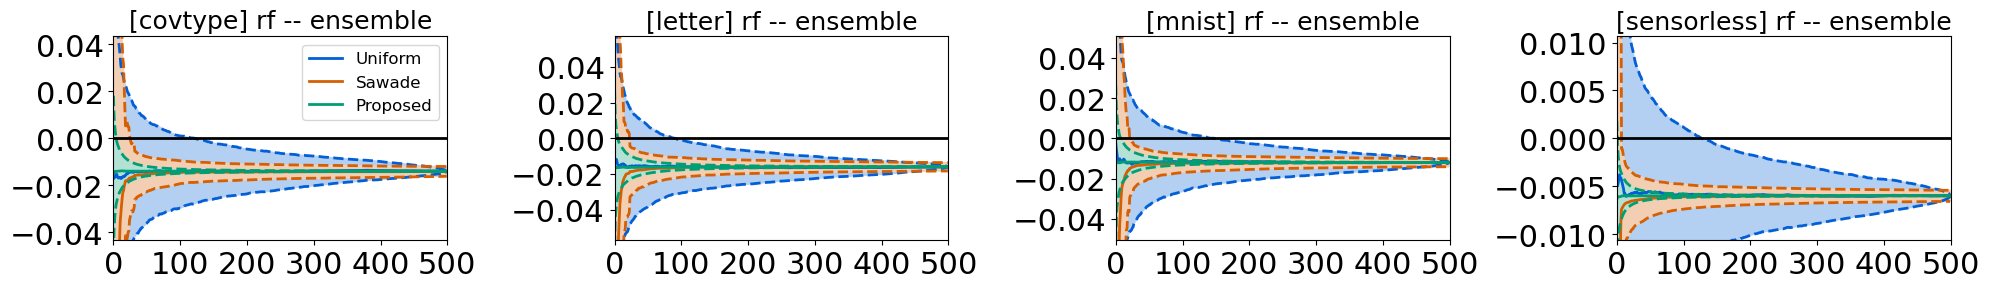

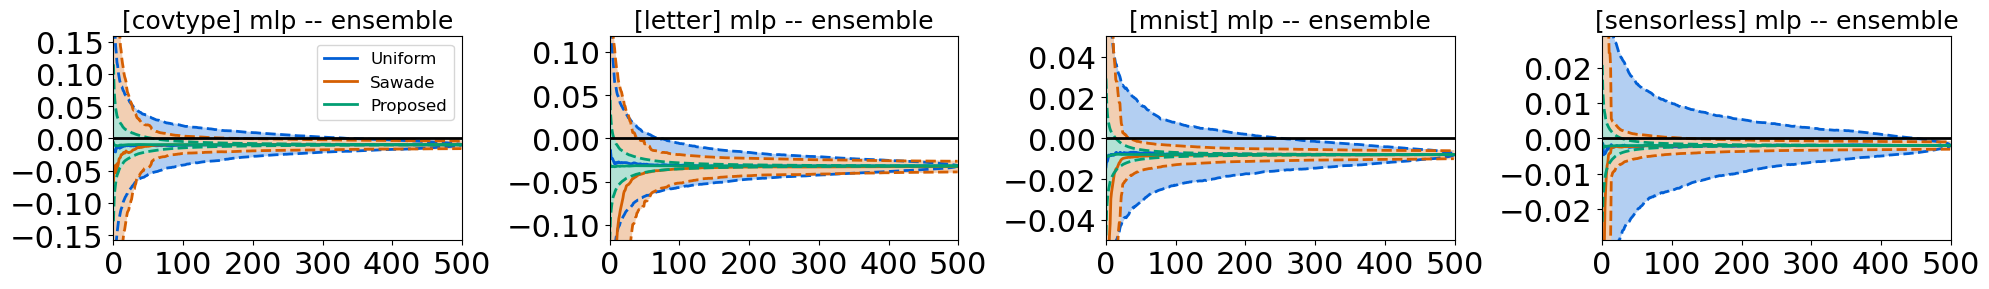

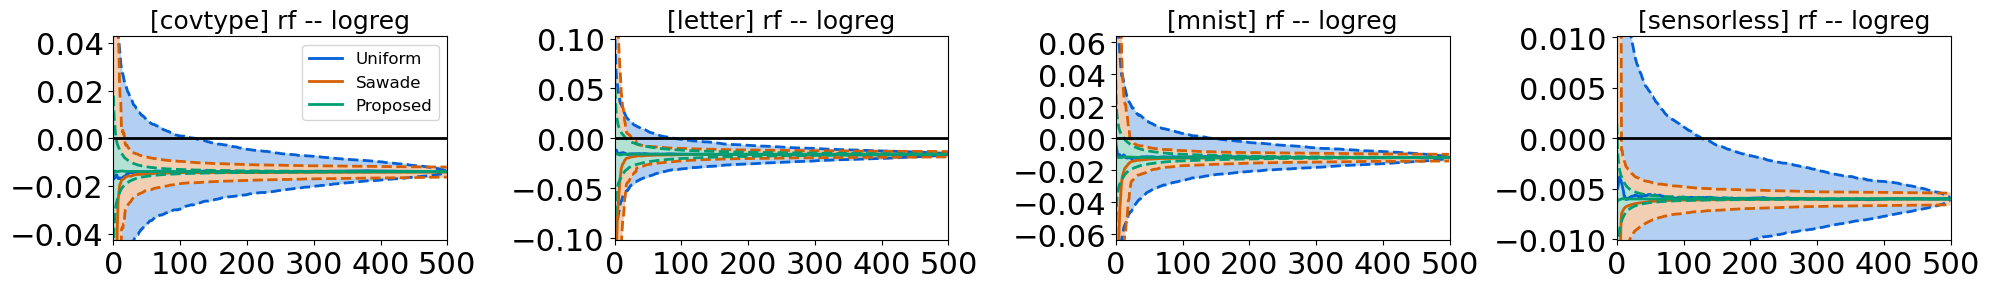

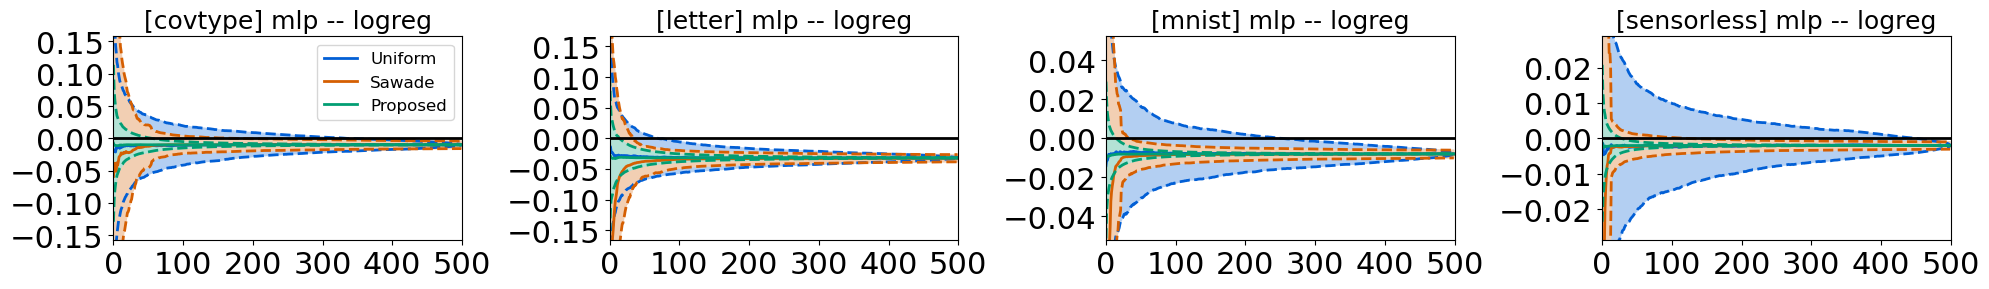

In [8]:
for s in surrogate:
    for m in model.keys():
        plt.figure(figsize=(20, 3))
        for i, d in enumerate(data):
            plt.subplot(1, len(data), i+1)
            plot_mean_std(2, d, methods, m, s, loss_fn, seed)
            plt.title('[%s] %s -- %s' % (d, m, s), fontsize=18)
            if i == 0:
                plt.legend(fontsize=12)
        plt.tight_layout()
        plt.show()

## Section 5.3

In [9]:
# settings
data = ['covtype', 'letter', 'mnist', 'sensorless']
model = {'rf':[10, 12, 14, 16, 18, 20], 'mlp':[30, 50, 100, 300, 500, 1000]}
surrogate = ['ensemble', 'logreg']
methods = {'uniform':('Uniform', (179/255, 207/255, 242/255), (2/255, 95/255, 213/255)),
            'sawade':('Sawade', (242/255, 207/255, 179/255), (213/255, 95/255, 2/255)),
            'proposed':('Proposed', (179/255, 226/255, 213/255), (2/255, 158/255, 115/255))}
loss_fn = 'zo'
seed = 0

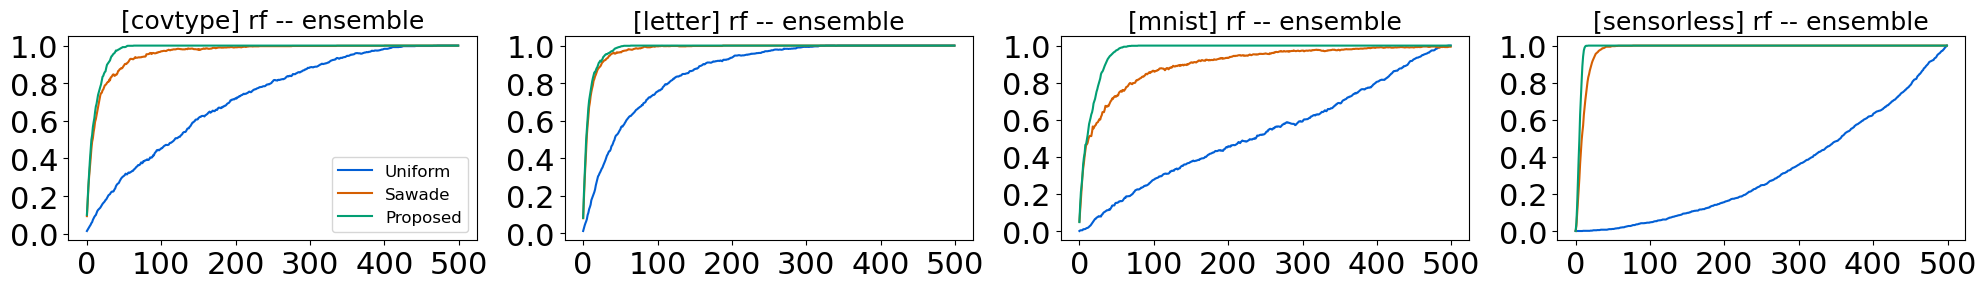

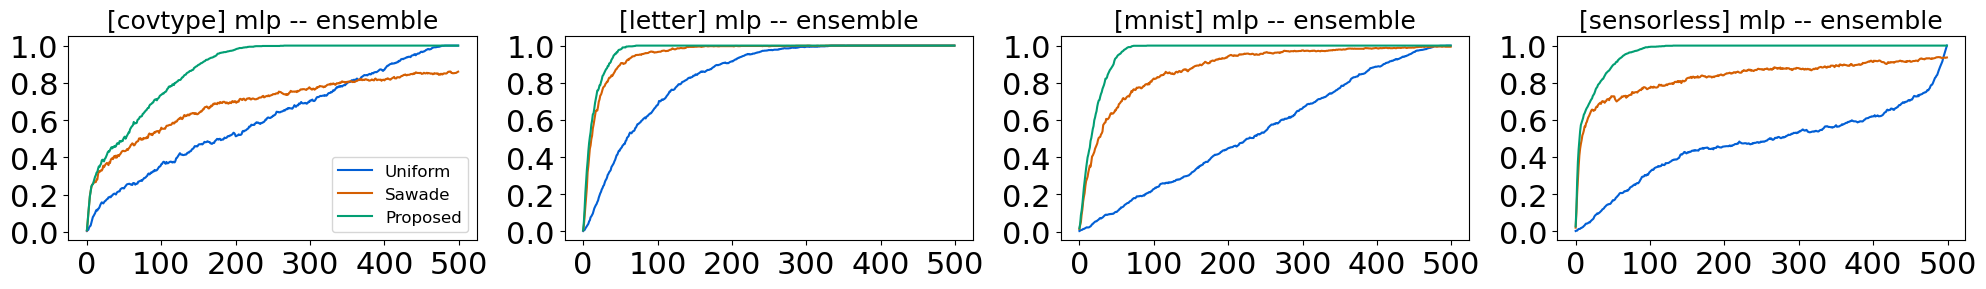

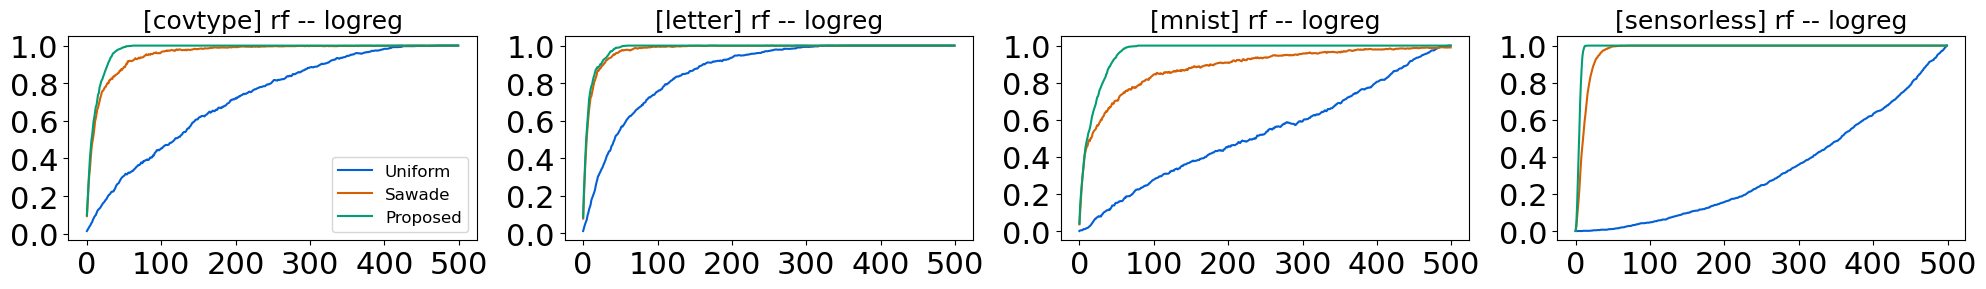

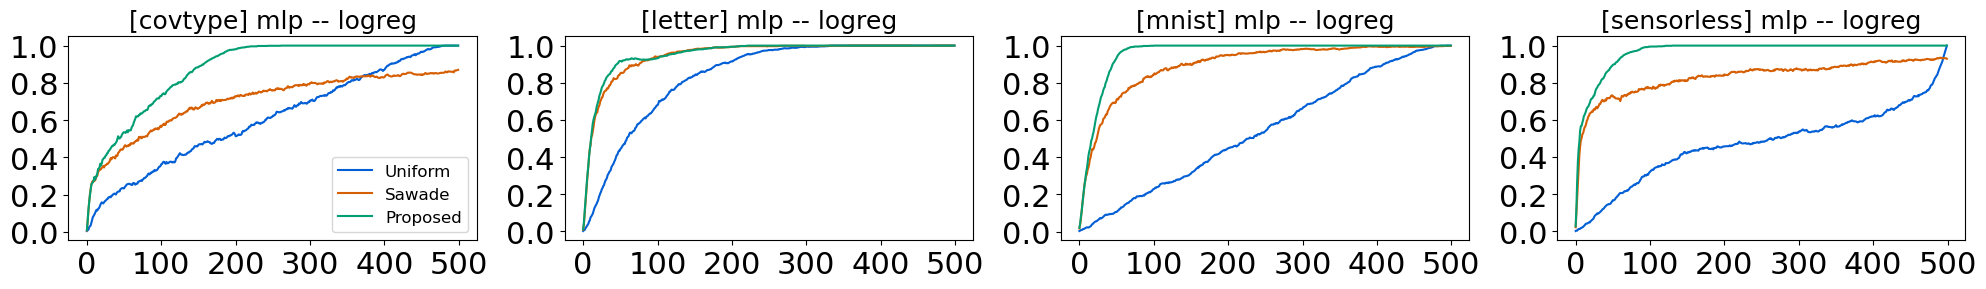

In [10]:
for s in surrogate:
    for m in model.keys():
        plt.figure(figsize=(20, 3))
        for i, d in enumerate(data):
            plt.subplot(1, len(data), i+1)
            plot_success(3, d, methods, m, s, loss_fn, seed)
            plt.title('[%s] %s -- %s' % (d, m, s), fontsize=18)
            if i == 0:
                plt.legend(fontsize=12)
        plt.tight_layout()
        plt.show()

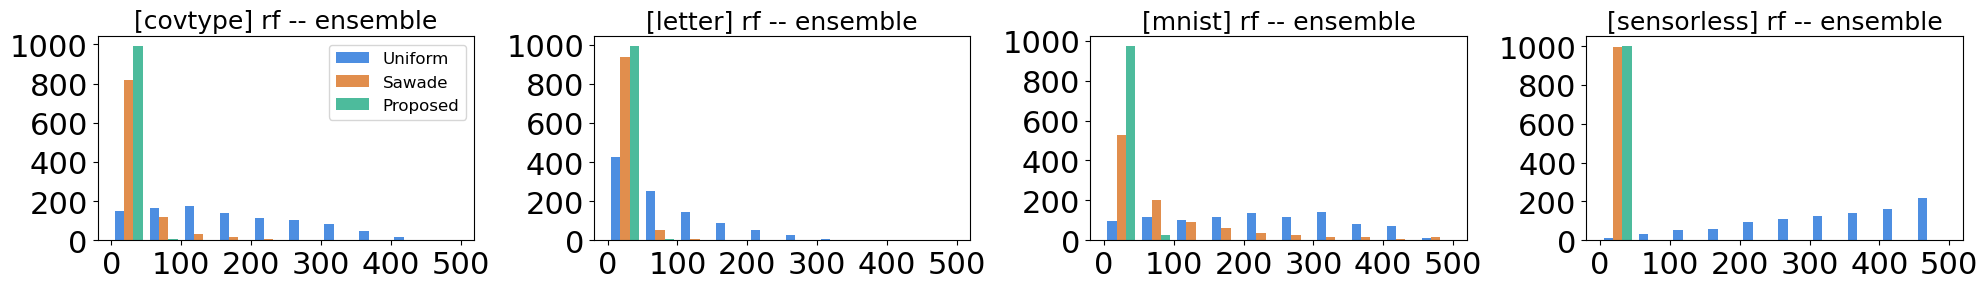

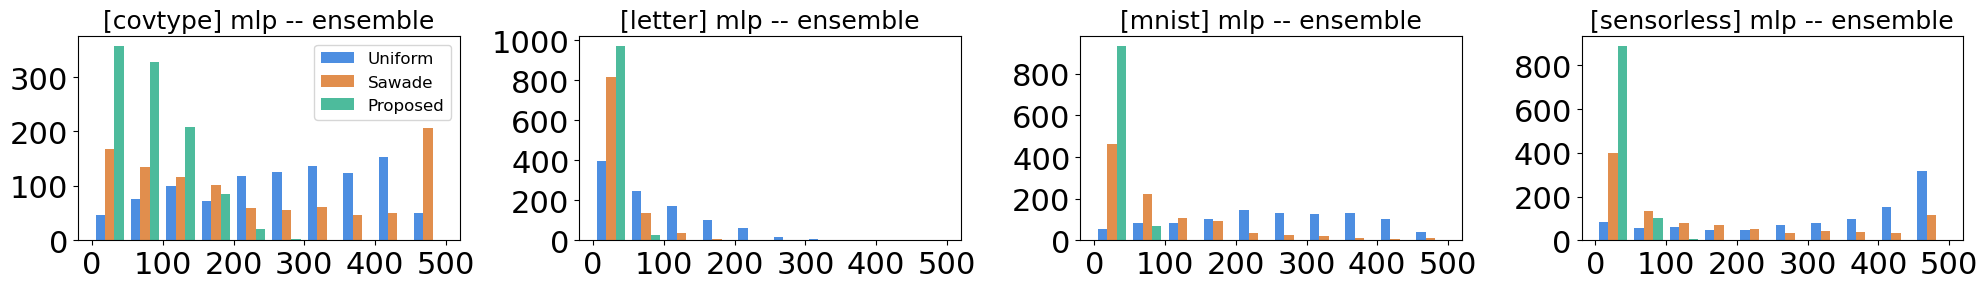

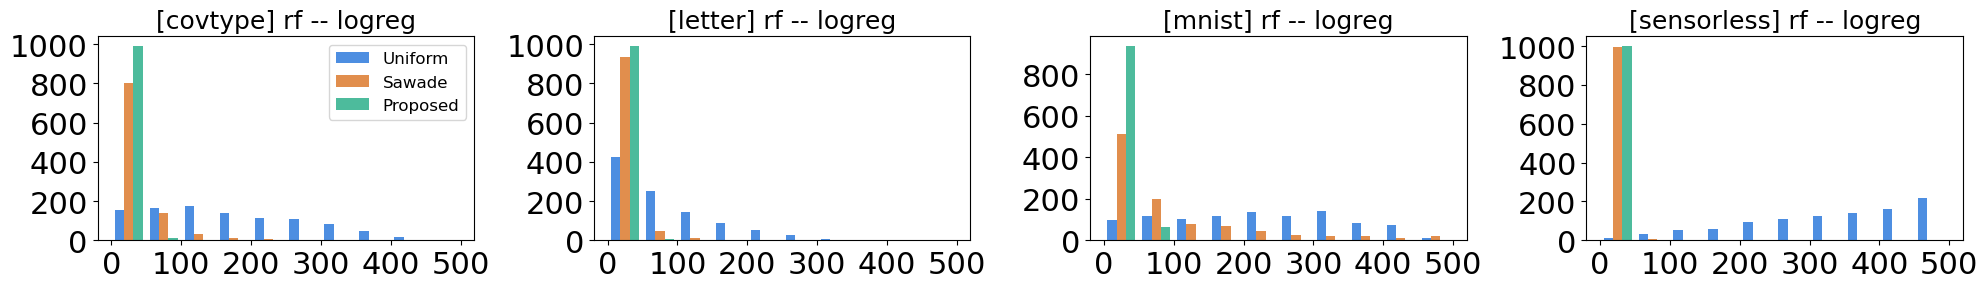

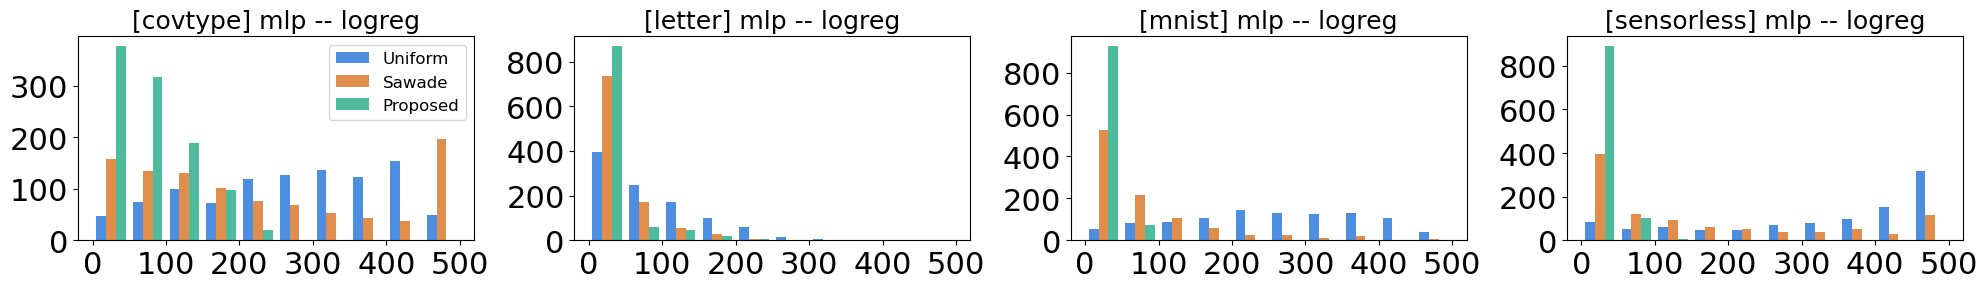

In [11]:
for s in surrogate:
    for m in model.keys():
        plt.figure(figsize=(20, 3))
        for i, d in enumerate(data):
            plt.subplot(1, len(data), i+1)
            plot_qnum(3, d, methods, m, s, loss_fn, seed)
            plt.title('[%s] %s -- %s' % (d, m, s), fontsize=18)
            if i == 0:
                plt.legend([methods[key][0] for key in methods.keys()], fontsize=12)
        plt.tight_layout()
        plt.show()